In [1]:
import pandas as pd
import numpy as np
from scipy import stats
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 그래프에서 마이너스 폰트 깨짐 대처
mpl.rcParams['axes.unicode_minus'] = False

# treat time
from datetime import datetime
import calendar

train = pd.read_csv('train.csv')
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['weekDay'] = train['date'].apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])
train['month'] = train['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])
train['season'] = train['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
train['weather'] = train['weather'].map({
    1:'Clear + Few clouds + Partly cloudy + Partly cloudy',
    2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
    3:' Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
})
categoryVariableList = ['hour','weekDay','month','season','weather','holiday','workingday']

for var in categoryVariableList:
    train[var] = train[var].astype('category')
train = train.drop(['datetime'], axis=1)

trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'].std())]

## 1. Filling 0's In windspeed Using Random Forest

### Read In Train Set and Test Set

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


아래 그래프를 보아 Train set과 Test set 모두 이상하게 windspeed에 0값이 가장 많음을 알 수 있다. 아마 측정되지 않은 값을 포함하여 모두 0으로 처리한 것이라 추측해보는데, 우선 이를 랜덤포레스트 모델을 통해 채워보자.

Text(0.5, 1.0, 'Windspeed in Train Set')

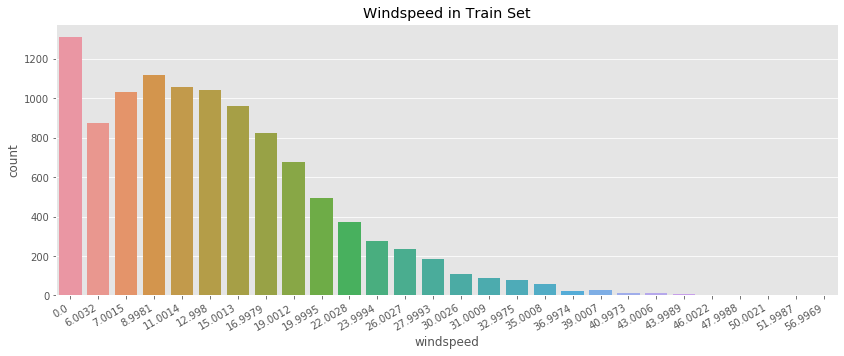

In [3]:
plt.figure(figsize=(14,5))
sns.countplot(x='windspeed', data=train)
plt.xticks(rotation=30, ha='right')
plt.title('Windspeed in Train Set')

Text(0.5, 1.0, 'Windspeed in Test Set')

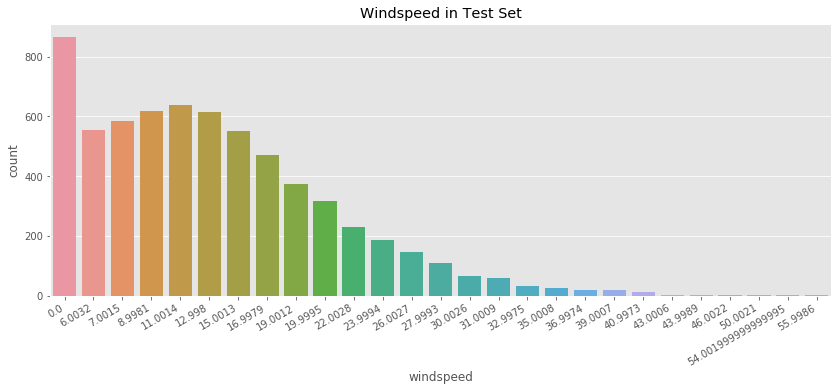

In [4]:
plt.figure(figsize=(14,5))
sns.countplot(x='windspeed', data=test)
plt.xticks(rotation=30, ha='right')
plt.title('Windspeed in Test Set')

### Combine Train and Test

In [5]:
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


### Feature Engineering

In [6]:
data['date'] = data['datetime'].apply(lambda x: x.split()[0])
data['hour'] = data['datetime'].apply(lambda x: x.split()[1].split(':')[0]).astype('int')
data['year'] = data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
data['weekday'] = data['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').weekday())
data['month'] = data['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').month)

### Random Forest Model To Predict 0's In Windspeed

In [7]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data['windspeed'] == 0]
dataWindNot0 = data[data['windspeed'] != 0]

rf_wind = RandomForestRegressor()

# 풍속에 영향을 주는 column들만 모아둔 리스트
windColumns = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

# windwpeed가 0이 아닌 데이터셋을 이용해 랜덤 포레스트 모델 학습
rf_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

# windspeed가 0인 데이터 포인트의 windspeed 예측
wind0Values = rf_wind.predict(X = dataWind0[windColumns])

dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

### Coercing To Categorical Type

In [8]:
data.columns

Index(['atemp', 'casual', 'count', 'datetime', 'holiday', 'humidity',
       'registered', 'season', 'temp', 'weather', 'windspeed', 'workingday',
       'date', 'hour', 'year', 'weekday', 'month'],
      dtype='object')

In [9]:
categoricalFeatureNames = ['season', 'holiday', 'weather', 'workingday','weekday', 'month', 'year','hour']
numericalFeatureNames = ['atemp','humidity','temp','windspeed']
dropFeatures = ['casual','datetime','registered','count','date']

In [10]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype('category')

### Splitting Train and Test Set  
  
전처리를 마친 data를 다시 Train Set과 Test Set으로 나눠준다.

In [48]:
train = data[pd.notnull(data['count'])].sort_values(by='datetime')
test = data[pd.isnull(data['count'])].sort_values(by='datetime')
datetimecol = test['datetime']
y_labels = train['count']
y_registered = train['registered']
y_casual = train['casual']

### Dropping Unnecessary Variables

In [12]:
train = train.drop(dropFeatures, axis=1)
test = test.drop(dropFeatures, axis=1)

In [13]:
train.head()

,atemp,holiday,humidity,season,temp,weather,windspeed,workingday,hour,year,weekday,month
15199,14.395,0,81,1,9.84,1,7.234610,0,0,2011,5,1
15200,13.635,0,80,1,9.02,1,6.842442,0,1,2011,5,1
15201,13.635,0,80,1,9.02,1,6.842442,0,2,2011,5,1
15202,14.395,0,75,1,9.84,1,6.907895,0,3,2011,5,1
15203,14.395,0,75,1,9.84,1,6.907895,0,4,2011,5,1


## 2. RMSLE Scorer  
이번 대회의 점수 산정 방식의 함수를 만든다.

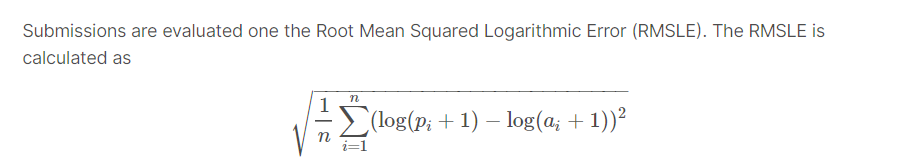
Where:  
- n is the number of hours in the test set
- p is your predicted count
- a is the actual count
- log(x) is the natural logarithm  
  
<RMSLE의 특징>
1. 과대평가 된 항목보다는 과소평가된 항목에 패널티
2. 작은 값일 수록 정밀도가 높다.(0)

In [14]:
def rmsle(y_pred, y_true, convertExp=True):
    if convertExp:
        y_pred = np.exp(y_pred)
        y_true = np.exp(y_true)
           
    # 예측값과 실제값에 1을 더하고 로그를 씌워준다.
    # np.nan_to_num 함수는 NaN을 0으로, inf값은 매우 큰 정수값으로 반환해줌
    log1 = np.nan_to_num(np.array([np.log(x + 1) for x in y_pred]))
    log2 = np.nan_to_num(np.array([np.log(x + 1) for x in y_true]))  
    
    # 위에서 계산한 예측값에서 실제값을 빼고 제곱을 해준다.
    cal = (log1 - log2) ** 2
    
    # 평균의 제곱을 반환한다.
    return np.sqrt(np.mean(cal))

## 3.Cross Validation(교차 검증)
- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습  
  
  
- k-fold CV  
   - 데이터를 폴드라 부르는 비슷한 크기의 부분 집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정
   - 첫 번째 폴드를 테스트 셋으로 사용하고 나머지 폴드를 훈련 셋으로 사용해 학습
   - 나머지 훈련 셋으로 만들어진 셋의 정확도를 첫 번째 폴드로 평가
   - 다음은 두 번째 폴드가 테스트 셋이 되고 나머지 폴드의 훈련 셋으로 학습 후 두 번째 폴드에 대한 정확도를 측정
   - 이 과정을 k-번째(마지막) 폴드까지 반복
   - 이렇게 훈련 셋과 테스트 셋으로 나누는 k개의 분할마다 정확도를 측정하여 평균 값을 낸 것이 곧 CV-정확도가 된다.

In [15]:
# k-fold 예시
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## 4. Build Models

### Linear Regression Model  
  
선형 회귀 모델은 가정 중 종속변수의 정규성이 있기 때문에 y에 로그를 취해준 값에 대하여 모델을 적합하고 예측한 뒤, 예측값에 다시 지수 변환을 해준다.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Initialize regression model
lr = LinearRegression()

# Train the model
y_log = np.log1p(y_labels) 
lr.fit(X=train, y=y_log)

# Make predictions
preds = lr.predict(X=train)
print('RMSLE Value For Linear Regression on Train set: {}'.format(rmsle(np.exp(y_log), np.exp(preds), False)))

RMSLE Value For Linear Regression on Train set: 0.9779779756087293


### Regularization Model - Ridge

Ridge는 회귀 계수가 0으로 다가가지만 0이 되지는 않는 L2 규제를 사용하며 alpha가 클수록 강한 규제 즉, 과대적합의 방향으로 나아간다.

In [17]:
from sklearn.linear_model import Ridge
ridge_m = Ridge()
# grid search를 진행할 파라미터 후보들
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# score를 내고 저장할 객체 생성 by metrics.make_scorer
rmsle_socrer = metrics.make_scorer(rmsle, greater_is_better=False) # 낮은 score가 좋은 성능을 나타내기에 greater_is_better=False 옵션을 넣어준다.

# 파라미터 후보와 점수를 저장할 객체를 지정한 Ridge 모델 객체 생성
grid_ridge_m = GridSearchCV(ridge_m, 
                           ridge_params,
                           scoring=rmsle_socrer,
                           cv = 5)

In [18]:
y_labelslog = np.log1p(y_labels)
grid_ridge_m.fit(train, y_labelslog)

pred = grid_ridge_m.predict(train)
print(grid_ridge_m.best_params_)
print('RMSLE Value For Ridge Regression: {}'.format(rmsle(np.exp(pred), np.exp(y_labelslog), False)))

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression: 0.9779779605420756


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

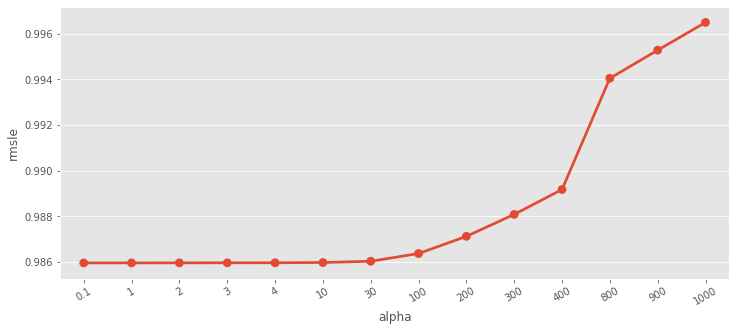

In [19]:
fig, ax = plt.subplots(figsize=(12,5))
df = pd.DataFrame(grid_ridge_m.cv_results_)
df['alpha'] = df['param_alpha']
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)

sns.pointplot(data=df, x=df['alpha'], y=df['rmsle'])
plt.xticks(rotation=30)

### Regularization Model - Lasso

Lasso 역시 Ridge와 비슷하게 규제를 사용하지만 L1 Reguralization을 사용하여 변수 선택의 효과가 나타나기도 한다. 마찬가지로 alpha 매개변수가 높을수록 강한 규제를 의미하며 과대적합의 방향으로 나아간다.

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

lasso = Lasso()

alpha = 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])
lasso_params = {'max_iter':[3000], 'alpha':alpha}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_lasso = GridSearchCV(lasso,
                         lasso_params,
                         scoring=rmsle_scorer,
                         cv=5)

In [21]:
y_labelslog = np.log1p(y_labels)
grid_lasso.fit(train, y_labelslog)

preds = grid_lasso.predict(train)
print(grid_lasso.best_params_)
print('RMSLE Value For Lasso Reg: {}'.format(rmsle(np.exp(y_labelslog), np.exp(preds), False)))

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Reg: 0.9781156258443623


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

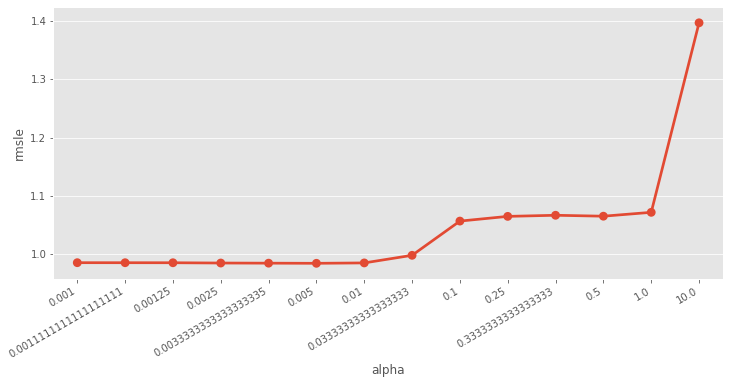

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
df = pd.DataFrame(grid_lasso.cv_results_)
df['alpha'] = df['param_alpha']
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)

sns.pointplot(data=df, x='alpha', y='rmsle')
plt.xticks(rotation=30, ha='right')

- 선형모델들은 훈련 셋에 대한 RMSLE score가 모두 0.97에 가까운 안좋은 성능을 낸다.

## Ensemble Models - Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, random_state=12)   # 100개의 의사결정 나무로 이루어진 랜덤 포레스트 객체 생성
y_labelslog = np.log(y_labels)

forest.fit(train, y_labelslog)
preds = forest.predict(train)
print('RMSLE Value For Random Forest: {}'.format(rmsle(np.exp(preds), np.exp(y_labelslog), False)))

RMSLE Value For Random Forest: 0.11097425868764658


- RMSLE socre는 0.1099정도로 선형모델에 비해 매우 좋은 성능을 보인다. GridSerchCV를 이용해 더 최적의 파라미터를 찾아보자.(과대적합을 방지하는 max_depth 매개변수를 이용)

In [37]:
forest = RandomForestRegressor(n_jobs=-1,random_state=12)
forest_params = {'n_estimators':[200], 'max_depth':[17,19,21,23]}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_forest = GridSearchCV(forest,
                          forest_params,
                          scoring= rmsle_scorer,
                          cv=5)
grid_forest.fit(train,y_labelslog)
preds = grid_forest.predict(train)

print(grid_forest.best_params_)
print('RMSLE Value For Random Forest: {}'.format(rmsle(np.exp(y_labelslog), np.exp(preds), False)))

{'max_depth': 23, 'n_estimators': 100}
RMSLE Value For Random Forest: 0.10982582270204776


## Ensemble Model - Gradient Boost

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01, random_state=12)
y_labelslog = np.log(y_labels)
gbm.fit(train, y_labelslog)
preds = gbm.predict(train)
print('RMSLE Value For Gradient Boost: {}'.format(rmsle(np.exp(preds), np.exp(y_labelslog), False)))

RMSLE Value For Gradient Boost: 0.20263728649213994


이제 train set과 test set 결과의 분포를 비교해보자. train set과 test set의 분포가 거의 동일해 보인다. 이 말은 즉슨 우리의 모델이 나쁜 예측을 하지 않았고, 과대 적합의 문제를 겪지 않을 것이란 걸 확인시켜준다.

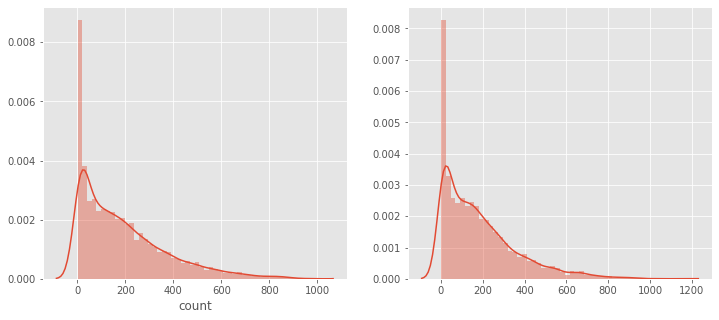

In [40]:
predtest = gbm.predict(test)
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.distplot(y_labels, bins=50, ax=ax[0])
sns.distplot(np.exp(predtest), bins=50, ax=ax[1])

### submission

In [53]:
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [54]:
submission['count'] = [max(0,x) for x in np.exp(predtest)]
submission.head()

,datetime,count
0,2011-01-20 00:00:00,8.936213
1,2011-01-20 01:00:00,4.867516
2,2011-01-20 02:00:00,3.102682
3,2011-01-20 03:00:00,1.867107
4,2011-01-20 04:00:00,1.349123


In [55]:
submission.to_csv('bike_prediction.csv', index=False)